## 1. Collect Basic Data

### Retrieve CryptoCurrency Market Data ###

In [1]:
import pandas as pd
import yfinance as yf
from functools import reduce
import requests
import time
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


CRYPTO = False

# Crypto Details
cryptoProducts = ["ETH-USD", "USDT-USD", "BTC-USD"]
availableGranularities = dict(zip(["1M", "5M", "15M", "1H", "6H", "1D"], [60, 300, 900, 3600, 21600, 86400]))

# Stock Details
dowTickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA"]  
sse50Tickers = ["600519.SS", "601318.SS", "601857.SS", "600036.SS", "600016.SS", "600000.SS"]  
sensexTickers = ["RELIANCE.BO", "TCS.BO", "INFY.BO", "ICICIBANK.BO", "SBIN.BO", "HINDUNILVR.BO"] 
ftse100Tickers = ["HSBA.L", "BP.L", "GSK.L", "SHEL.L", "BATS.L", "ULVR.L"]  
period = "1D"
indexProducts = dowTickers + sse50Tickers + sensexTickers + ftse100Tickers
productIds = indexProducts

if CRYPTO:
    productIds = cryptoProducts
    period = "6H"
    granularity = availableGranularities[period]
    API_THRESHOLD = 300 #Can only get 300 periods at a time from API
    PERIODS_WANTED = 2500

# not a chance
def retrieveCryptoData(productID, granularity, daysBack, endTime):
    API_URL = f"https://api.exchange.coinbase.com/products/{productID}/candles"
    daysBackDaysAgo = timedelta(days=daysBack)
    startTime = datetime.fromisoformat(endTime) - (granularity/86400) * daysBackDaysAgo

    # Convert to isoformat
    startTime = startTime.isoformat()

    # Set Request Parameters
    parameters = {
        "start" : startTime,
        "end" : endTime,
        "granularity" : str(granularity)
    }

    # Actually get data
    data = requests.get(API_URL, params = parameters, headers = {"content-type":"application/json"})
    df = pd.DataFrame(data.json(), columns=["time", "low", "high", "open", "close", "volume"])
    return df


def retrieveIndexData(ticker):
    # Define date range
    startDate = "2009-01-01"
    endDate = "2020-08-05"

    ohlcData = {}
    try:
        stockData = yf.download(ticker, start=startDate, end=endDate)
        ohlcData[ticker] = stockData[["Low", "High", "Open", "Close", "Volume"]]
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

    dfOhlc = pd.concat(ohlcData, axis=1)
    return dfOhlc


dataframes = dict()
RETRIEVE_DATA = False

if RETRIEVE_DATA:
    for productId in productIds:
        if CRYPTO:
            # Fetch PERIODS_WANTED periods of data
            end = (datetime.now()).isoformat()
            for batch in range(PERIODS_WANTED // API_THRESHOLD  + 1):
                amountToFetch = PERIODS_WANTED % API_THRESHOLD if batch == PERIODS_WANTED // API_THRESHOLD else API_THRESHOLD
                tempDF = retrieveCryptoData(productId, granularity, amountToFetch, end)
                timeInSeconds = (tempDF['time'].values)[-1]
                dt = datetime.fromtimestamp(timeInSeconds - granularity)
                end = dt.isoformat() + 'Z'
                value = dataframes.get(productId)
                if productId not in dataframes:
                    dataframes[productId] = tempDF[::-1]
                else:
                    dataframes[productId] = pd.concat([tempDF[::-1], dataframes[productId]])
        else:
            dataframe = retrieveIndexData(ticker=productId)
            columnNames = [value[1].lower() for value in list(dataframe.columns.values)]
            dataframe.columns = columnNames
            dataframes[productId] = dataframe
   
# Required for index data that pull stock data from different exchanges
def commonaliseData(data):
    commonDates = reduce(lambda x, y: x.intersection(y), [df.index for df in data.values()])
    for ticker, df in data.items():
        data[ticker] = df.reindex(commonDates)
        data[ticker]["Times"] = commonDates
    data = {ticker: df.dropna() for ticker, df in data.items()}
    PERIODS_WANTED = data.get(indexProducts[0]).shape[0]
    return data

if not CRYPTO and RETRIEVE_DATA:
    dataframes = commonaliseData(dataframes)

In [2]:
TEST_CORRECT_ORDER = False

if TEST_CORRECT_ORDER:
    testTime = dataframes[productIds[0]]['time'].values
    testTime -= testTime[0]
    plt.figure(figsize=(10, 6))
    plt.plot(testTime, color="blue")
    plt.title(f"Test Correct Order")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

## 2. Augment State Space (add indicators)

### Indicator 1: Exponential Moving Average ###

In [3]:
import matplotlib.pyplot as plt

def EMA(array, N):
    """
    EMA_t = (Price_t * α) + (EMA_(t-1) * (1 - α))
    where:
    EMA_t = Exponential Moving Average at time t
    Price_t = Price at time t
    α (alpha) = Smoothing factor, calculated as 2 / (N + 1)
    N = Number of periods
    """
    smoothingParameter = 2/(N + 1)
    finalArray = [array[0]]
    for i in range(1, len(array)):
        finalArray.append(array[i] * smoothingParameter + finalArray[i-1] * (1 - smoothingParameter))
    return np.array(finalArray)

# expMA = EMA(closingPrices, t)
# plt.figure(figsize=(10, 6))
# plt.plot(expMA, label=f"Exponential Moving Average: T={t}", color="red")
# plt.plot(closingPrices, label="Actual Closing Prices", color="blue")
# plt.title(f"Price Data")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

### Indicator 2: Momemtum

In [4]:
def Momentum(array):
    # Percentage Change in Price/Time
    momentumArray = [(array[i] - array[i-1]) /array[i-1] for i in range(1, len(array))]
    momentumArray.insert(0, np.nan)
    return np.array(momentumArray)

# momentum = Momentum(closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(momentum*100, color="green")
# plt.title(f"Momentum Data (as %)")
# plt.xlabel("Time")
# plt.ylabel("Momentum")
# plt.legend()
# plt.show()

### Indicator 3: Average True Range

In [5]:

def trueRange(high, low, close):
    # TR = Max[(H - L), |H - C|, |L - C|
    closing = np.insert(close, 0, np.nan, axis=0)[:len(close)]
    return np.maximum(high - low, np.abs(high - closing), np.abs(low - closing))

def averageTrueRange(high, low, close, n=14):
    trueRanges = trueRange(high, low, close)
    atr = np.empty_like(trueRanges)
    atr[:n] = np.nan  # First n values are NaN
    atr[n-1] = np.mean(trueRanges[:n])  # Initial ATR value (simple average of the first n TRs)
    for i in range(n+1, len(trueRanges)):
        atr[i] = (atr[i-1] * (n - 1) + trueRanges[i]) / n
    return atr

# aTRIndicator = averageTrueRange(highs, lows, closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(aTRIndicator, color="Brown")
# plt.title(f"Average True Range over Time")
# plt.xlabel("Time")
# plt.ylabel("Average True Range")
# plt.legend()
# plt.show()

### Indicator 4: Commodity Channel Index

In [6]:
def commodityChannelIndex(high, low, close, n=20):
    # (Typical Price - 20_Day Moving Average) / .015 x Mean Deviation
    typicalPrices = (high + low + close) / 3
    
    movingAverage = np.full_like(high, np.nan)
    meanDeviation = np.full_like(high, np.nan)
    
    for i in range(n, len(typicalPrices)):
        movingAverage[i] = np.mean(typicalPrices[i-n:i])
        meanDeviation[i] = np.mean(np.abs(typicalPrices[i-n:i] - movingAverage[i]))
    
    cci = np.full_like(high, np.nan, dtype=np.float64)

    numerator = typicalPrices[n:] - movingAverage[n:]
    denominator = 0.015 * meanDeviation[n:]
    result = np.empty_like(numerator)

    np.divide(numerator, denominator, out=result, where=(denominator != 0))
    # a little hacky...
    result[denominator == 0] = 0

    cci[n:] = result
    return cci

# # CCI = commodityChannelIndex(highs, lows, closingPrices)
# # plt.figure(figsize=(10, 6))
# # plt.plot(CCI, color="black")
# # plt.title(f"Commodity Channel Index over Time")
# # plt.xlabel("Time")
# # plt.ylabel("Commodity Channel Index")
# # plt.legend()
# # plt.show()

### Indicator 5: MACD

In [7]:
"""
MACD = 12-day EMA - 26-day EMA
Signal Line = 9-day EMA of MACD
MACD Histogram = MACD - Signal Line
where EMA stands for Exponential Moving Average
"""

def MACD(array):
    return EMA(array, 12) - EMA(array, 26)

def MACDSignal(array):
    return EMA(MACD(array), 9)

MACDHistogram = lambda x : MACD(x) - MACDSignal(x)

# mACD = MACD(closingPrices)
# signalLine = MACDSignal(closingPrices)
# macdHistogram = MACDHistogram(mACD, signalLine)

# plt.figure(figsize=(10, 6))
# plt.plot(mACD, color="blue", label = "MACD Line")
# plt.plot(signalLine, color = "red", label = "Signal Line")
# plt.plot(macdHistogram, color = "black", label = "Histogram")
# plt.title(f"Moving Average Convergence-Divergence")
# plt.xlabel("Time")
# plt.ylabel("MACD")
# plt.legend()
# plt.show()

## 3. Collate All Features Into DataFrame

In [8]:
import os

CCI_T, ATR_T = 20, 14
if RETRIEVE_DATA:
    for product in productIds:
        df = dataframes[product]
        close = df["close"].values
        highs = df["high"].values
        lows = df["low"].values
        df['E_M_A'] = EMA(close, N=30)
        df['Momentum'] = Momentum(close)
        df['Av_True_Range'] = averageTrueRange(highs, lows, close, 14)
        df['CCI'] = commodityChannelIndex(highs, lows, close, 20)
        df['MACDHist'] = MACDHistogram(close)
        df["Return"] = df["close"].pct_change().fillna(0)
        # Reset Indexes
        df = df.drop(columns=['open', 'high', 'volume', 'low'])
        df = df.iloc[max(ATR_T, CCI_T):]
        df = df.reset_index(drop=True)
        dataframes[product] = df
        if not os.path.exists("CSVs/"):
            os.makedirs("CSVs/")
        df.to_csv(f"CSVs/{product}_{period}_periods.csv", sep='\t')
else:
    for productId in productIds:
        df = pd.read_csv(f"CSVs/{productId}_{period}_periods.csv", sep='\t')
        dataframes[productId] = df.iloc[:, 1:]  # Drops the first column

times = None
if not CRYPTO:
    for product in productIds:
        df = dataframes[product]
        times = df['Times']
        dataframes[product] = df.drop('Times', axis=1)

## 4. Environment and Training Process

### Comparison Strategies

In [9]:
sse50BuyAndHold =  np.array([0] + [1/len(sse50Tickers) if i in sse50Tickers else 0 for i in productIds])
sensexBuyAndHold = np.array([0] + [1/len(sensexTickers) if i in sensexTickers else 0 for i in productIds])
ftse100BuyAndHold = np.array([0] + [1/len(ftse100Tickers) if i in ftse100Tickers else 0 for i in productIds])
dowBuyAndHold = np.array([0] + [1/len(dowTickers) if i in dowTickers else 0 for i in productIds])
buyAndHoldAll = np.array([0] + [1/(len(productIds)) for i in productIds])

#Non
NON_RL_COMPARISON_STRATEGIES = {
    "SSEBuyAndHold" : sse50BuyAndHold,
    "SENSEXBuyAndHold" : sensexBuyAndHold,
    "FTSEBuyAndHold" : ftse100BuyAndHold,
    "DOWBuyAndHold" : dowBuyAndHold,
    "BuyAndHoldAll" : buyAndHoldAll
}

### Hyperparameters (most of them)

In [10]:
from collections import defaultdict


NUMBER_OF_ASSETS = len(productIds)
NUMBER_OF_FEATURES = 1 + (len((list(dataframes.values())[0]).columns)) * len(productIds)
if not CRYPTO:
    PERIODS_WANTED = list(dataframes.values())[0].shape[0]
EXPERIMENTS = 2
TRAINING_PERIODS = int(PERIODS_WANTED / EXPERIMENTS) # will probably have to change this to times
TIME_WINDOW = 30
LEARNING_FREQUENCIES = (TRAINING_PERIODS / np.array([10, 20, 30, 40, 50])).astype(int)
START_CASH = 1000000
LSTMHIDDENSIZE = 128
AGENT_RISK_AVERSIONS = np.array([0.25, 0.5, 1, 1.5, 2]) #i know, this probably shouldn't go here
STRATEGIES = ["PPOLSTM", "RANDOM"]#, "TD3"] #td3 requires debugging - dont run
FINAL_STRATEGIES = STRATEGIES + ["SSEBuyAndHold", "SENSEXBuyAndHold", "FTSEBuyAndHold", "DOWBuyAndHold", "BuyAndHoldAll"]
REPEATS = 5 # Computational Limitations
LSTMOUTPUTSIZES = [64, 128, 256, 512, 1024]
STARTS = [0] + [i *  TRAINING_PERIODS + -TIME_WINDOW for i in range(1, EXPERIMENTS)]
PORTFOLIO_TRAJECTORIES = []
REWARD_FUNCTIONS = ["Standard Logarithmic Returns" ,"Differential Sharpe Ratio_0.01", "Differential Sharpe Ratio_0.05", "Differential Sharpe Ratio_0.1", "CVaR"]
NUMBER_OF_PARALLEL_ENVIRONMENTS = [0, 1, 2, 3, 4]
LEARNING_RATES = [1e-4, 3e-4, 5e-4, 7e-4]
RL_STRATS = ["PPOLSTM"]#, "TD3"]
averagePerformance = defaultdict(list)
allResults = defaultdict(list)

In [11]:
# Thing being tested
TESTING = {
    "RISK AVERSION" : False,
    "LSTM OUTPUT SIZE" : False,
    "REWARD FUNCTION" : False,
    "LEARNING FREQUENCY": False, 
    "PARALLEL ENVIRONMENTS" : False, 
    "LEARNING RATE": False,
}

#### Some helper functions for metrics

In [12]:
from utils import tabulate_neatly

def printConfiguration(agent=None, freq=None):
    table = [["LSTM Hidden Size", "LSTM Output Size", "Learning Frequency", "Agent Risk Aversion"]]
    table.append([LSTMHIDDENSIZE, agent.state_n, freq, agent.riskAversion])
    tabulate_neatly(table, headers="firstrow", title=f"Configuration:")

def plotAllocations(allocations, title=None):
    categories = ['Cash'] + productIds
    plt.figure(figsize=(20,5))
    plt.bar(categories, allocations)
    plt.xlabel('Allocations')
    plt.tick_params(axis='x', labelsize=6)
    plt.ylabel('Proportion Allocated')
    plt.title('Allocations' if title == None else title)
    plt.show()

def generateConfigLabel(strategy, agent, episode, rewardFunction, freq, parr, lr):
    firstTag = f"Strategy-{strategy}" 
    lastTag = f"Experiment {episode + 1}"
    innerTag = None
    boole = (strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM")
    if TESTING["RISK AVERSION"]:
        innerTag = (f"Risk Aversion-{agent.riskAversion}" if boole else "")
    elif TESTING["LSTM OUTPUT SIZE"]:
        innerTag = (f"LSTM Output Size-{agent.state_n}" if boole else "")
    elif TESTING["REWARD FUNCTION"]:  
        innerTag = (f"Reward Function-{rewardFunction}" if boole else "")
    elif TESTING["LEARNING FREQUENCY"]:  
        innerTag = (f"Learning Frequency-{freq}" if boole else "")
    elif TESTING["PARALLEL ENVIRONMENTS"]:  
        innerTag = (f"Parallel Environments-{parr}" if boole else "")
    elif TESTING["LEARNING RATE"]:  
        innerTag = (f"Learning Rate-{lr}" if boole else "")
    
    if any(TESTING.values()) and boole:
        firstTag, innerTag = innerTag, firstTag
    return firstTag + " | " +  innerTag + " | " + lastTag


### Actual Training

In [13]:
from PPO import PPOAgent
from TD3 import TD3Agent

def generateAgent(strat, lstmOutputSize, riskAversion, lr):
    if strat == "TD3":
        return TD3Agent(
                state_n=lstmOutputSize,
                actions_n=len(productIds) + 1,
                alpha=lr,
                beta=0.001,
                gamma=0.99,
                tau=0.005,
                lstmHiddenSize = LSTMHIDDENSIZE,
                actor_noise=0.01,
                target_noise=0.01,
                env=None,
                batch_size=128,
                fc1_n=512,
                fc2_n=384,
                riskAversion=riskAversion,
            )
    elif strat == "PPOLSTM":
        return PPOAgent( 
                        state_n=lstmOutputSize, 
                        actions_n=len(productIds) + 1,
                        alpha=lr,
                        policyClip = 0.2,
                        gamma=0.99,
                        lstmHiddenSize=LSTMHIDDENSIZE,
                        actor_noise=0,
                        batch_size=512,
                        fc1_n=128,
                        fc2_n=128,
                        gaeLambda=0.98,
                        epochs=10,
                        riskAversion=riskAversion,
                    )

In [ ]:
import torch
from PPO import PPOAgent
from TD3 import TD3Agent
from LstmFeatureExtractor import LstmFeatureExtractor
from TimeSeriesEnvironment import TimeSeriesEnvironment
from scipy.special import softmax
import numpy as np

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

def initializeEnvironments(start, parr, rewardFunction, riskAversion, strategy):
    primaryEnvironment = TimeSeriesEnvironment(dataframes, start, TIME_WINDOW, TRAINING_PERIODS, START_CASH, riskAversion, 2.5e-4)
    parallelEnvironments = [
        TimeSeriesEnvironment(dataframes, start, TIME_WINDOW, TRAINING_PERIODS, START_CASH, riskAversion, 2.5e-4)
        for _ in range(parr)
    ]
    primaryEnvironment.TD3 = strategy == "TD3"
    for parallel in parallelEnvironments:
        parallel.TD3 = strategy == "TD3"
    if "Differential" in rewardFunction:
        decay = float(rewardFunction.split("_")[1])
        primaryEnvironment.decayRate = decay
        for env in parallelEnvironments:
            env.decayRate = decay
    return primaryEnvironment, parallelEnvironments

def storeExperiences(agent, data, outputs, reward, done, strategy, parr, action, prob, val, next):
        if strategy == "PPOLSTM":
            agent.store(data, action, prob.squeeze(), val.squeeze(), reward, done)
            for i in range(parr):
                agent.store(
                    data,
                    outputs["actions"][i],
                    outputs["probabilities"][i].squeeze(),
                    outputs["valuations"][i].squeeze(),
                    float(outputs["rewards"][i]),
                    bool(outputs["dones"][i])
                )
        elif strategy == "TD3":
            agent.store(
                data,
                action,
                reward,
                next, 
                done,
            )
            for i in range(parr):
                agent.store(
                    data,
                    outputs["actions"][i],
                    float(outputs["rewards"][i]),
                    next,
                    bool(outputs["dones"][i])
                )


def warmUpEnvironment(environment, strategy, parallelEnvironments, rewardFunction):
    """
    'warm up' primaryEnvironmentironment until there's enough data to calculate CVaR
    """
    for _ in range(TIME_WINDOW):
        allocations = np.random.normal(scale=1, size=len(productIds))
        allocations = np.insert(allocations, 0, 1)
        environment.step(softmax(allocations), False, rewardMethod=rewardFunction)
        if strategy in RL_STRATS:
            for parallel in parallelEnvironments:
                parallel.step(softmax(allocations), False, rewardMethod=rewardFunction)
    environment.setIsReady(True)
    if strategy in RL_STRATS:
        for parallel in parallelEnvironments:
            parallel.setIsReady(True)
            parallel.TD3 = strategy == "TD3"

def trainingLoop(riskAversion=0, lstmOutputSize=512, rewardFunction="CVaR", freq=int(TRAINING_PERIODS / 25), parr=0, lr=3e-4):
    for repeat in range(REPEATS):
        for strategy in STRATEGIES:
            if repeat > 0 and strategy not in (RL_STRATS + ["RANDOM"]):
                continue

            for episode in range(EXPERIMENTS):
                start = episode * TRAINING_PERIODS + (0 if episode == 0 else -TIME_WINDOW)
                featureExtractor = LstmFeatureExtractor(TIME_WINDOW, NUMBER_OF_FEATURES, 128, lstmOutputSize)
                agent = generateAgent(strategy, lstmOutputSize, riskAversion, lr)
                primaryEnvironment, parallelEnvironments = initializeEnvironments(start, parr, rewardFunction, riskAversion, strategy)
                primaryEnvironment.reset()
                done, doNothing = False, False

                while not done:
                    if not primaryEnvironment.getIsReady():
                        warmUpEnvironment(primaryEnvironment, strategy, parallelEnvironments, rewardFunction)
                        continue

                    readyToStartTrading = (primaryEnvironment.timeStep) / TRAINING_PERIODS >= 2 / 3
                    observation, outputs = None, None

                    if strategy in RL_STRATS:
                        data = primaryEnvironment.getData()
                        observation = featureExtractor.forward(torch.tensor(data, dtype=torch.float32).unsqueeze(0))
                        if strategy == "PPOLSTM":
                            outputs = {
                                "actions": torch.zeros(parr, agent.actions_n),
                                "probabilities": torch.zeros(parr, agent.actions_n),
                                "valuations": torch.zeros(parr, 1),
                                "rewards": torch.zeros(parr, 1),
                                "dones": torch.zeros(parr, 1)
                            }
                            for i in range(parr):
                                act, prob, val = agent.select_action(observation)
                                outputs["actions"][i] = act
                                outputs["probabilities"][i] = prob
                                outputs["valuations"][i] = val
                        else:
                            outputs = {
                                "nextstates" : torch.zeros(parr, agent.state_n),
                                "actions" : torch.zeros(parr, agent.actions_n),
                                "rewards" : torch.zeros(parr, 1),
                                "dones" : torch.zeros(parr, 1)
                            }
                            for i in range(parr):
                                act = agent.select_action(observation)
                                outputs["actions"][i] = act # noise added to action so its fine
                        allCashAction = np.array([1] + [0 for _ in productIds]) if doNothing else None

                    probabilities, valuation = None, None
                    if strategy == "RANDOM":
                        action = np.random.normal(0, 1, len(productIds) + 1)

                    elif strategy in NON_RL_COMPARISON_STRATEGIES:
                        action = NON_RL_COMPARISON_STRATEGIES.get(strategy)
                    else: 
                        if strategy == "PPOLSTM":
                            action, probabilities, valuation = agent.select_action(observation)
                        elif strategy == "TD3":
                            action = agent.select_action(observation) 
                            
                    if not doNothing:
                        primaryEnvironment.traded += 1

                    finalAction = (
                        allCashAction if doNothing else ([0] + action if strategy in NON_RL_COMPARISON_STRATEGIES else softmax(action))
                    )
                    next, reward, done, _, info = primaryEnvironment.step(finalAction, readyToStartTrading, rewardFunction)
                    
                    if strategy in RL_STRATS:
                        for i in range(parr):
                            nexts, rew, do, _, _ = parallelEnvironments[i].step(finalAction, readyToStartTrading, rewardFunction)
                            if strategy == "TD3":
                                outputs["nextstates"][i] = nexts
                            outputs["rewards"][i] = rew
                            outputs["dones"][i] = int(do)
                        if not doNothing:
                            storeExperiences(agent, data, outputs, reward, done, strategy, parr, action, probabilities, valuation, next)
                            doNothing = info["turbulence_breached"]
                        if (primaryEnvironment.timeStep % freq) == 0:
                            agent.train(featureExtractor)

                    if done:
                        dataString = generateConfigLabel(strategy, agent, episode, rewardFunction, freq, parr, lr)
                        averagePerformance[dataString].append(primaryEnvironment.PORTFOLIO_VALUES)
                        metrics = primaryEnvironment.getMetrics()
                        allResults[dataString].append(metrics)
                        table = [metrics.keys()]
                        table.append(metrics.values())
                        tabulate_neatly(table, headers="firstrow", title=f"{dataString}")
                        # if strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM":
                            #nice but take up way too much space...
                            # printConfiguration(agent, freq)
                            # plotAllocations([0] + action if strategy in NON_RL_COMPARISON_STRATEGIES.keys() else softmax(action), "Final Allocations")
                        

### Visualise Performance ###

In [ ]:
if not CRYPTO:
    result = np.array_split(times, STARTS, axis=0)[1:]
    timeScale = [dates for dates in result]

def plotPerformance(test, final=""):
    for experiment in range(EXPERIMENTS):
        plt.figure(figsize=(12,6))
        relevantPeriods = int(2/3 * TRAINING_PERIODS) + 2
        name = f"Experiment_{experiment + 1}_" 
        portfolioFolder = f"portfolios/Test-{test+final}/"+ datetime.now().strftime("%Y-%m-%d") + "/"
        plotsFolder = f"plots/Test-{test+final}/"+ datetime.now().strftime("%Y-%m-%d") + "/"
        if not os.path.exists(portfolioFolder):
            os.makedirs(portfolioFolder)
        if not os.path.exists(plotsFolder):
            os.makedirs(plotsFolder)
        for k, v in averagePerformance.items():
            # if test.lower() in k.lower() or "RANDOM" in k: # i wrote this at 12am forgive me
            #     shouldBeSkipped = False
            #     for value in list(NON_RL_COMPARISON_STRATEGIES.keys())[:-1]:
            #         if value in k:
            #             shouldBeSkipped = True # only need to compare with buy and hold for now
            #     if shouldBeSkipped:
            #         continue
                try:
                    x = np.array(v)
                    x = np.mean(v, axis=0)
                    v = x
                except ValueError:
                    maxLength = max(len(arr) for arr in v)
                    result = []
                    for i in range(maxLength):
                        values = [arr[i] for arr in v if i < len(arr)]
                        mean_value = np.mean(values)
                        result.append(mean_value)
                    v = result
                v= v[relevantPeriods:]
                if f"Experiment {experiment + 1}" in k:
                    l = k.split("|")[0]
                    array = np.insert(v, 0, START_CASH)
                    # labels = timeScale[experiment][-15:]           
                    # labelIndices = range(0, len(labels), 1)  
                    # plt.xticks(labelIndices, rotation=45)
                    plt.plot(array, label=l) ## too tired
                    np.savetxt(f"{portfolioFolder}{name}{l}.txt", array, fmt='%f')
        plt.title(f"Returns over Time - Experiment {experiment + 1}. Testing: {test}")
        plt.xlabel("Time")
        plt.ylabel("Mean Returns")
        plt.legend()
        plt.savefig(f"{plotsFolder}{name}")
        plt.show()



C:\Users\bluem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


### Tabulate Results

In [16]:
def tabulateResults():
    for k, v in allResults.items():
        table = [list(v[0].keys()) + ["Standard Deviation"]] 
        meanReturns, meanMER, meanPB, meanAPPT, meanSR, timeSteps = 0, 0, 0, 0, 0, 0
        deviations = []
        for resultSet in v:
            meanReturns += resultSet["Cumulative \nReturn (%)"]
            deviations.append(resultSet["Cumulative \nReturn (%)"])
            meanMER += resultSet["Maximum Earning \nRate (%)"]
            meanPB += resultSet["Maximum \nPullback (%)"]
            meanAPPT += (resultSet["Average Profitability \nper Trade"] if type(resultSet["Average Profitability \nper Trade"]) == float else 0)
            meanSR += resultSet["Sharpe Ratio"]
            timeSteps += resultSet["Total Timesteps"]
        array = [meanReturns, meanMER, meanPB, meanAPPT, meanSR, timeSteps, np.std(deviations)]
        array = [i/len(v) for i in array]
        table.append(array)
        tabulate_neatly(table, headers="firstrow", title=f"MEAN RESULTS FOR: " + k)

In [17]:
def test():
    for testType, active in TESTING.items():
        if active:
            print(f"TESTING {testType.replace('_', ' ').upper()}")
            testLoops = {
                "RISK AVERSION": lambda: [
                    trainingLoop(riskAversion=risk) for risk in AGENT_RISK_AVERSIONS
                ],
                "LSTM OUTPUT SIZE": lambda: [
                    trainingLoop(lstmOutputSize=size) for size in LSTMOUTPUTSIZES
                ],
                "REWARD FUNCTION": lambda: [
                    trainingLoop(
                        riskAversion=(0.25 if r == "CVaR" else 0), rewardFunction=r
                    )
                    for r in REWARD_FUNCTIONS
                ],
                "LEARNING FREQUENCY": lambda: [
                    trainingLoop(freq=fr) for fr in LEARNING_FREQUENCIES
                ],
                "PARALLEL ENVIRONMENTS": lambda: [
                    trainingLoop(parr=par) for par in NUMBER_OF_PARALLEL_ENVIRONMENTS
                ],
                "LEARNING RATE": lambda: [
                    trainingLoop(lr=learn) for learn in LEARNING_RATES
                ],
            }
            
            testLoops[testType]()
            break 


def runTests():
    for key in TESTING.keys():
        print("=" * 50)
        TESTING[key] = True
        test()
        plotPerformance(key)
        TESTING[key] = False
        print("=" * 50)
    tabulateResults()

TEST = False
# Run the tests
if TEST:
    runTests()

### Best Models (if any) Evaluated 

Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
44.46,52.35,19.7407,1214.78,0.1124,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-0.69,12.86,38.3981,-18.7954,-0.0015,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
42.88,44.91,18.705,1171.7,0.1121,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
0.7,14.5,53.2119,19.1026,0.0014,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.71,29.06,50.8531,374.686,0.0366,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-0.1,8.94,58.2766,-2.81721,-0.0002,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.29,19.23,36.9882,363.241,0.0411,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
15.86,17.76,28.9847,433.325,0.0337,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
46.92,49.34,43.0805,1282.07,0.1164,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.2,13.5,33.5312,278.81,0.0201,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
25,31.23,22.7144,682.963,0.073,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.68,16.53,44.2194,319.236,0.0236,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.21,19.01,35.3558,278.962,0.0294,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
5.81,22.48,40.3254,158.678,0.0119,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
29.77,33.28,37.1037,813.425,0.0809,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
12.52,21.69,46.4343,342.114,0.0264,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
25.08,32.34,30.1729,685.224,0.0749,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
12.05,21.48,43.9334,329.247,0.0237,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
34.59,43.81,25.7213,945.062,0.0835,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.73,30.58,49.1265,730.458,0.0533,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.63,22.67,32.5551,590.986,0.0685,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
43.33,45.95,41.1958,1183.89,0.0665,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.29,30.43,17.9126,527.023,0.0563,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
4.72,14.45,48.8669,129.023,0.01,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.44,35.03,30.9191,913.719,0.0947,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
0.68,7.36,51.2084,18.4527,0.0015,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16,27,39.3804,437.282,0.0472,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
4.66,14.18,44.935,127.386,0.0105,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
52.62,67.39,28.2337,1437.58,0.1011,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-0.21,5.38,59.6802,-5.66703,-0.0004,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.77,26.69,49.9897,540.187,0.0561,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.53,26.85,35.4218,670.167,0.0506,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.27,31.47,39.4042,745.177,0.0704,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.14,31.94,52.0762,823.531,0.0495,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.35,24.46,30.1227,474.041,0.0483,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-0.33,18.6,44.3156,-8.93255,-0.0007,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.13,26,21.2245,303.989,0.0336,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-1.65,10.99,52.4496,-45.1282,-0.0035,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
29.63,34.84,33.6519,809.626,0.0898,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.91,22.02,34.3469,516.613,0.0369,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.21,50.89,38.3294,907.469,0.0795,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
12.79,15.58,42.4843,349.566,0.0296,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.34,49.3,28.4984,992.961,0.1008,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.92,12.68,49.5982,325.731,0.0246,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.53,23.87,29.3954,533.574,0.0577,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
46.57,48.01,54.9655,1272.32,0.077,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.02,40.27,35.0381,902.208,0.0902,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
6.32,17.59,41.2309,172.803,0.0131,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
46.5,54.92,41.5185,1270.6,0.1112,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.46,28.42,45.5114,640.925,0.0428,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.52,36.16,39.3385,888.595,0.0965,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.3,36.44,36.1585,909.855,0.0627,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.83,30.65,24.0754,623.668,0.0624,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
0.04,8.47,44.2667,1.07808,0.0001,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.85,27.68,42.8466,651.529,0.071,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.95,21.31,33.4545,326.47,0.0239,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.66,33.3,36.9762,646.462,0.0633,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
12.9,28.41,41.6279,352.492,0.0244,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31.26,39.42,40.6394,854.005,0.078,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-13.43,13.62,46.7994,-366.979,-0.0296,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.83,46.14,27.2093,842.349,0.0663,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
14.54,16.27,50.2064,397.35,0.0321,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.23,22.47,29.463,498.127,0.053,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
3.69,20.36,43.8575,100.862,0.008,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
52.59,58.42,24.6186,1436.8,0.1177,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.15,21.76,45.4477,277.452,0.0228,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.68,27.28,24.5173,646.967,0.0691,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-3.13,8.36,37.3788,-85.4984,-0.0077,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.36,22.23,31.8471,474.309,0.0519,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
3.52,18.15,51.4187,96.1899,0.0071,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
53.29,56.01,45.6143,1455.89,0.1362,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.22,31.95,54.0356,607.166,0.0435,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.15,22.39,23.1176,495.813,0.0545,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.97,41.56,40.4522,491.048,0.0296,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
38.3,41.06,30.5747,1046.51,0.108,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-6.85,7.6,50.7252,-187.228,-0.0151,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.29,38.39,33.2213,827.594,0.0782,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-9.23,5.47,40.6112,-252.189,-0.0208,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.39,39.37,30.0245,830.276,0.084,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.69,18.38,40.8422,292.143,0.023,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
35.8,41.75,25.8331,978.068,0.0912,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
3.88,6.52,57.0661,106.081,0.0081,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.8,37.5,25.058,923.484,0.0933,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.93,24.83,40.847,626.54,0.0487,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31.01,38.67,38.972,847.307,0.0828,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-4.31,-0.83,54.3476,-117.742,-0.0096,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.38,29.51,25.2929,720.685,0.0818,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.72,25.12,42.7482,511.545,0.0366,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.27,26.13,38.3301,553.881,0.0578,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-6.74,5.35,41.6961,-184.019,-0.0159,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
46.74,46.74,24.5774,1276.96,0.1263,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-0.81,2.16,43.0726,-22.0802,-0.0019,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
8.21,20.69,32.4849,224.389,0.0241,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
0.15,7.79,37.9124,4.12723,0.0003,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
43.24,46.34,38.085,1181.47,0.1075,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.49,25.17,39.2843,368.476,0.0285,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.44,20.72,34.3351,449.287,0.0476,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
41.6,46.18,41.8243,1136.73,0.0659,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.88,23.32,22.8051,543.071,0.0595,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
4.44,14.91,46.1659,121.446,0.0091,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.02,33.03,44.2221,711.018,0.067,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
14.39,18,32.6964,393.257,0.0285,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.29,41.6,43.0838,882.225,0.0811,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
5.22,18.73,52.719,142.607,0.0107,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.74,25.85,36.7651,457.315,0.0502,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.22,25.05,45.1311,634.5,0.053,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.28,24.05,39.7493,499.427,0.0575,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-3.01,14.12,43.6507,-82.1983,-0.0064,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.92,30.91,16.0804,762.705,0.0771,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.94,30.69,45.2288,298.98,0.0197,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
29.88,34.61,27.9123,816.369,0.0841,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
1.94,2.48,45.991,53.0233,0.0046,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.67,34.89,32.2241,838.061,0.0843,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-11.03,-1.85,50.5323,-301.327,-0.0299,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.65,35.59,20.4028,837.45,0.0793,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-6.48,4.02,58.2137,-177.054,-0.0151,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.18,30.98,38.9101,606.083,0.0677,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-8.32,5.99,65.6899,-227.371,-0.0195,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
46.53,54.16,19.3587,1271.41,0.1167,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.86,19.48,41.8541,324.009,0.0238,1101


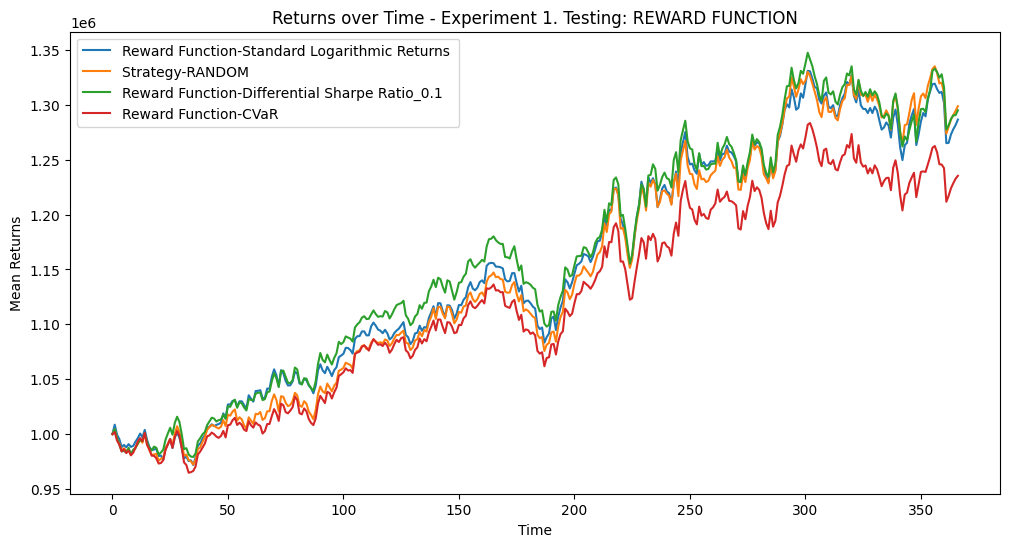

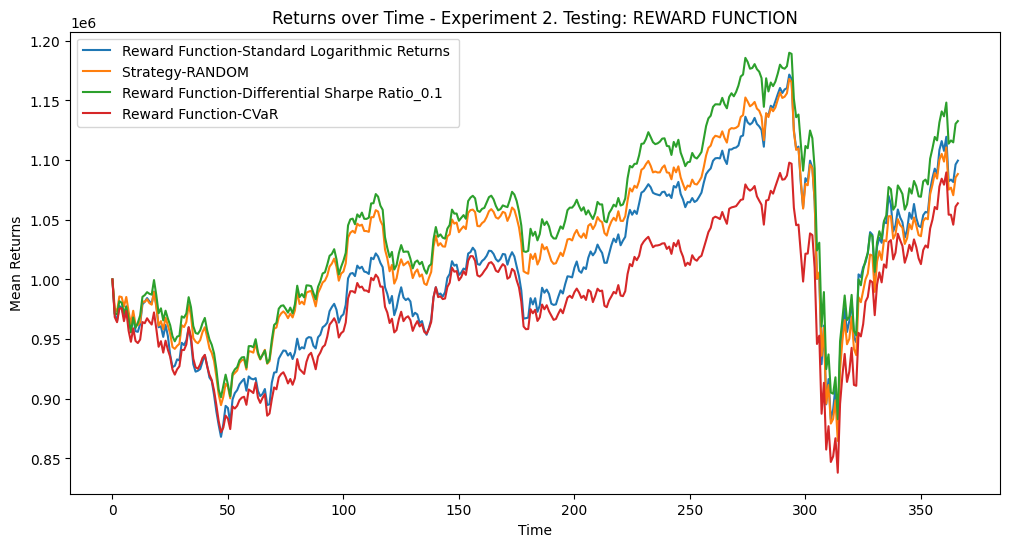

Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.44,29.04,22.4699,503.734,0.0492,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.63,27.93,26.8316,673.041,0.0522,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.38,30.67,23.0042,556.847,0.0591,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.77,20.83,50.7614,540.184,0.039,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.14,47.04,37.3504,905.404,0.0756,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-31.66,0.83,49.6192,-1018.05,-0.0815,1046


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
28.36,37.13,32.3255,774.738,0.0822,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.74,29.4,37.1911,675.838,0.0488,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.66,33.9,24.6215,646.314,0.0642,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.43,11.97,35.8737,284.901,0.0217,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
40.36,45.46,34.4613,1102.66,0.1011,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.17,21.02,49.2099,496.336,0.037,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
49.86,53.05,35.0299,1362.42,0.1369,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
12.77,14.55,43.8051,348.784,0.0278,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.06,32.83,28.5152,657.316,0.0696,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.07,33,43.0103,548.39,0.038,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.98,28.77,34.1577,518.561,0.0527,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-2.88,12.33,32.4567,-78.5998,-0.0068,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.35,39.02,35.4281,883.77,0.0888,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.59,23.43,48.8366,316.651,0.0227,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.7,29.25,27.0333,729.391,0.0819,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.63,23.15,55.5153,563.761,0.0388,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
38.46,43.75,27.2865,1050.75,0.1001,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
4.36,13.46,40.2439,119.145,0.0089,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.21,29.88,33.9279,634.182,0.0656,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
8.88,11.16,47.4155,242.545,0.018,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.88,31.4,23.2459,652.544,0.0646,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
4.25,16.52,48.3041,116.196,0.0088,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.98,26.9,42.0068,518.587,0.0559,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-0.3,7.53,52.5833,-8.11382,-0.0007,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31.3,35.2,37.2029,855.268,0.0826,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.81,19.06,51.2065,459.358,0.0364,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.68,30.47,41.0194,756.239,0.0648,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
12.99,15.58,28.6535,355.054,0.0317,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.91,26.97,38.9628,516.59,0.054,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.34,18.92,45.9704,309.871,0.0232,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
29.46,32.63,42.5459,804.833,0.0797,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-1.65,12.17,45.1171,-44.9984,-0.0035,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
14.6,23.15,27.0427,398.806,0.0441,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
5.13,12.39,56.4254,140.047,0.0109,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.5,39.28,39.9197,724.139,0.0652,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.68,42.89,39.4589,1002.25,0.0679,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
38.17,40.34,30.2916,1042.93,0.1046,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.5,19.6,33.1175,368.717,0.0269,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
15.07,27.76,29.9462,411.712,0.0402,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-3.11,5.87,62.4572,-85.1038,-0.0065,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.45,26.99,25.8311,585.979,0.0616,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.92,19.94,37.4466,489.514,0.0372,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.9,38.56,44.6588,898.863,0.0836,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-4.93,11.09,57.3222,-134.768,-0.0098,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.42,32.22,31.9121,721.767,0.0711,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
5.41,10.64,43.4241,147.723,0.0119,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.3,20.14,28.6633,308.745,0.0332,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-5.98,0.89,51.0292,-163.309,-0.013,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.51,29.92,43.3247,669.537,0.0651,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
2.22,18.76,39.9965,60.7475,0.0048,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.24,28.95,45.2766,662.192,0.0736,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
6.95,13.64,47.1167,190.016,0.0155,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.83,31.41,36.8572,651.217,0.0707,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.96,20.53,40.6469,381.414,0.0281,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
48.86,50.55,19.8429,1334.93,0.1189,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
1.1,28.71,44.5451,30.1063,0.0021,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
35.27,43.46,30.3545,963.542,0.0961,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
3.15,14.23,39.7934,86.1896,0.0067,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.36,46.97,39.7461,993.337,0.0948,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
6.8,15,39.3581,185.72,0.0143,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
9.65,22.48,38.9668,263.666,0.0301,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-2.46,14.42,40.1368,-67.2143,-0.0054,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
52.82,60.69,32.9913,1443.28,0.1302,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
0.49,24.74,41.7472,13.2742,0.001,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
28.03,35.01,30.4435,765.771,0.0764,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.02,19,56.127,273.882,0.0204,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.96,24.96,35.0056,681.968,0.0709,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
8.35,23.49,44.3539,228.019,0.018,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.82,38.02,21.6141,842.118,0.0826,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.32,21.38,41.7822,473.108,0.0341,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.07,37.61,41.1171,712.37,0.0635,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-10.73,5.6,49.3701,-293.254,-0.0226,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.1,23.89,31.2026,576.629,0.0649,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
8.91,19.05,52.0178,243.495,0.0177,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
35.84,42.77,34.4435,979.228,0.0984,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
1.16,7.14,48.9013,31.623,0.0021,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.69,25.23,41.198,537.918,0.0568,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.94,22.32,46.7733,462.966,0.0344,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
15.87,23.24,35.5535,433.672,0.0451,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
7.46,10.19,45.1163,203.745,0.0159,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
29.76,31.01,25.1824,813.059,0.0814,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.6,27.65,43.3012,316.832,0.0238,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.92,31.62,28.3991,626.36,0.0692,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
5.99,23.42,42.2761,163.711,0.0112,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
14.76,20.68,29.9885,403.158,0.0443,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-1.36,11.99,50.617,-37.1532,-0.0029,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31.63,46.56,24.9841,864.309,0.0698,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.79,20.14,49.3648,485.942,0.0382,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
38.63,40.68,31.661,1055.52,0.1168,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
38.01,41.79,38.3285,1038.62,0.0623,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.82,33.96,38.7726,759.979,0.0783,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
15.01,17.97,53.4721,410.203,0.0268,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.32,28.59,35.3149,555.101,0.059,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
15.68,20.11,43.4128,428.371,0.0338,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
34.82,47.91,33.0081,951.241,0.0767,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.92,21.43,42.205,325.688,0.0255,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
28.47,29.99,31.5707,777.873,0.0832,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
5.13,19.29,42.34,140.27,0.0106,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
7.99,19.08,33.9455,218.225,0.0236,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-2.27,2.71,58.9517,-62.0203,-0.0056,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
29.07,34.77,35.891,794.138,0.0814,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.93,13.31,39.5321,325.959,0.0253,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.1,33.04,39.8594,603.722,0.0652,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
1.09,14.53,50.1946,29.825,0.0022,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
28.8,34.59,42.1303,786.918,0.0805,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.02,32.48,47.9817,820.214,0.0551,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31.03,38.72,23.7101,847.834,0.0881,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
6.74,20.06,44.548,184.053,0.0131,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
47.1,48.08,29.7377,1286.75,0.1283,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.09,24.95,39.0175,630.757,0.0472,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.48,52.04,24.4899,996.8,0.0802,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
28.45,31.14,39.2521,777.336,0.049,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.38,26.78,30.1426,665.998,0.072,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
7.84,15.72,47.0385,214.248,0.0161,1101


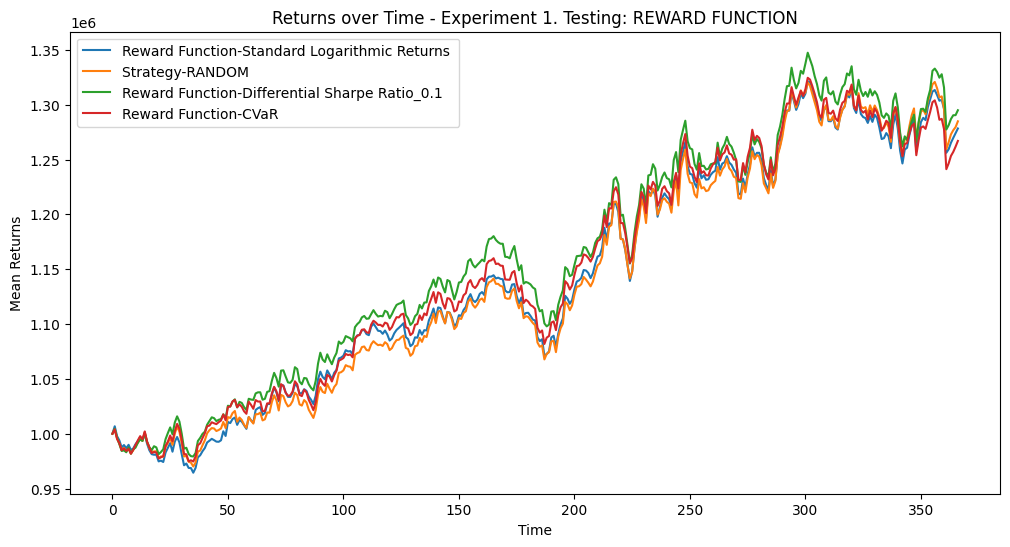

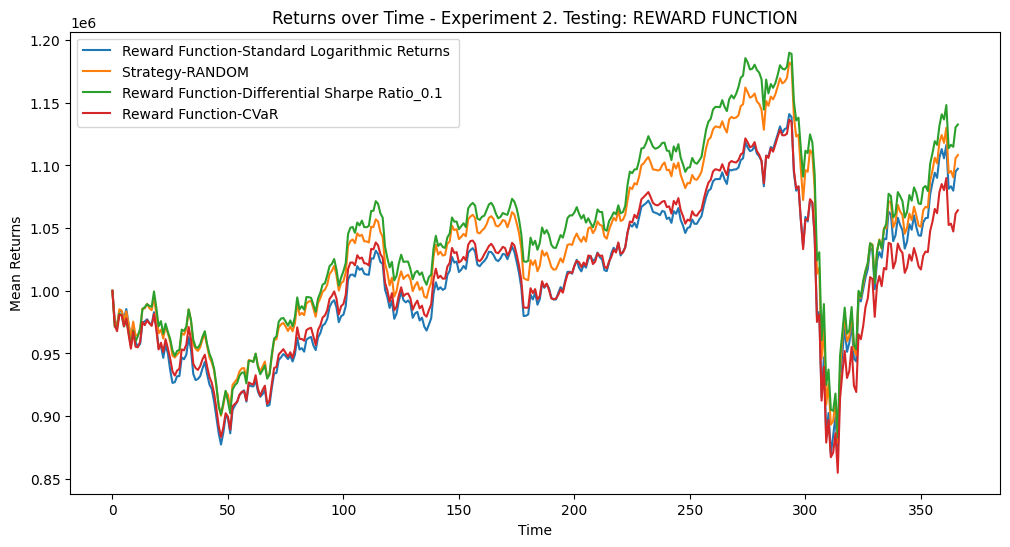

MEAN RESULTS FOR: Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
27.829,35.2795,33.5851,0,0.073225,1101,0.60447


MEAN RESULTS FOR: Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
7.67,15.904,44.4473,0,0.013265,1098.25,0.746759


MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
28.4835,34.3007,31.771,0,0.0789217,1101,0.153836


MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
10.8337,19.1943,44.208,0,0.0215417,1101,0.168958


MEAN RESULTS FOR: Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
29.495,38.12,31.0309,0,0.07427,1101,1.13688


MEAN RESULTS FOR: Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.271,23.21,45.6992,0,0.02447,1101,1.42228


MEAN RESULTS FOR: Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
26.6947,34.9343,33.7497,0,0.0706167,1101,0.344613


MEAN RESULTS FOR: Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
6.42467,16.118,47.4389,0,0.01153,1101,0.428697


In [ ]:
# REMEMBER TO VARY BUT REPEAT SEEDS
# To test:
# Exp 1:
# RF: RiskAversion = 0.25, DSR = 0.1. LogRet
# Output Size = 256
# Frequency = 36
# Envs = 3
# LR = 5e-4

# Exp 2:
# RF: RiskAversion = 0.5, 1.5, CVaR, LogRet
# Output Size = 1024
# Frequency = 36
# Envs = 0
# LR = 3e-4

REPEATS = 10

# Experiment 1
EXP_1_CONFIG = {"Reward" : ["Standard Logarithmic Returns", "Differential Sharpe Ratio_0.1", "CVaR"],
                "LSTM Output Size" : 256, 
                "Frequency" : 36,
                "Environments" : 3,
                "Learning Rate" : 5e-4,
                }
EXP_2_CONFIG = {"Reward" : ["Standard Logarithmic Returns", "CVaR_0.5", "CVaR_1.5"],
                "LSTM Output Size" : 1024, 
                "Frequency" : 36,
                "Environments" : 0,
                "Learning Rate" : 3e-4,
                }

def runFinal():
    #terrible code forgive me

    # Configuration 1
    allResults = defaultdict(list)
    print("=" * 50)
    TESTING["REWARD FUNCTION"] = True
    for r in EXP_1_CONFIG["Reward"]:
        trainingLoop(
        riskAversion=(0.25 if r == "CVaR" else 0),
        rewardFunction=r,
        freq=EXP_1_CONFIG["Frequency"],
        parr=EXP_1_CONFIG["Environments"],
        lstmOutputSize=EXP_1_CONFIG["LSTM Output Size"],
        lr=EXP_1_CONFIG["Learning Rate"],
    )
    plotPerformance("REWARD FUNCTION", "SecondLast")
    TESTING["REWARD FUNCTION"] = False
    print("=" * 50)

    # Configuration 2
    print("=" * 50)
    allResults = defaultdict(list)
    TESTING["REWARD FUNCTION"] = True
    for r in EXP_2_CONFIG["Reward"]:
        trainingLoop(
        riskAversion=(float(r.split("_")[1]) if r.split("_")[0] == "CVaR" else 0),
        rewardFunction=r.split("_")[0],
        freq=EXP_2_CONFIG["Frequency"],
        parr=EXP_2_CONFIG["Environments"],
        lstmOutputSize=EXP_2_CONFIG["LSTM Output Size"],
        lr=EXP_2_CONFIG["Learning Rate"],
    )
    plotPerformance("REWARD FUNCTION", "SecondLast")
    TESTING["REWARD FUNCTION"] = False
    print("=" * 50)
    
    tabulateResults()

RUN_FINAL = True
if RUN_FINAL:
    runFinal()
